In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import os
import random
import csv

In [2]:
label_def = {'axis': 11, 'bearing': 10, 'container_box_blue': 14, 
             'container_box_red': 15, 'em_01': 17, 'em_02': 18,
             'f20_20_B': 1, 'f20_20_G': 3, 'm20': 6, 'm20_100': 5, 'm30': 7,
             'motor': 13, 'r20': 8, 's40_40_B': 2, 'background': 19}
IMAGE_DIMENSION = [480, 640]
NUM_OF_SCALES = 2
GET_OBJ_DET_LABEL = True
NUM_IMAGES = 50
IMAGE_PATH = './objects/image'
LABEL_PATH = './objects/label'
LABEL_IMG_TYPE = '.png'
NUM_ANNOTATIONS = 28 # currently 1 label in axis is missing
MAX_OBJECTS_PER_IMAGE = 6

In [3]:
object_paths = dict()
label_paths = dict()
for obj_dir in os.listdir(IMAGE_PATH):
    obj_files = list()
    for files in sorted(os.listdir(os.path.join(IMAGE_PATH, obj_dir))):
        obj_files.append([os.path.join(IMAGE_PATH, obj_dir, files), 
                         os.path.join(LABEL_PATH, obj_dir, files.split('.')[0]+LABEL_IMG_TYPE)])
    object_paths[obj_dir] = obj_files.copy()

In [4]:
def get_random_locations(num_objects_to_place):
    #row = np.random.randint(0, 440, size= num_objects_to_place).reshape(-1, 1)
    #col = np.random.randint(0, 600, size= num_objects_to_place).reshape(-1, 1)
    row = [random.randrange(0, 440, 30) for _ in range(num_objects_to_place)]
    col = [random.randrange(0, 600, 30) for _ in range(num_objects_to_place)]
    row = np.array(row).reshape(-1, 1)
    col = np.array(col).reshape(-1, 1)
    return np.hstack((row, col))

In [5]:
num_objects = NUM_OF_SCALES * (len(label_def) - 1) * NUM_ANNOTATIONS
objects_index = np.arange(0, num_objects)

background_files = os.listdir('./backgrounds')
background_files = [os.path.join('./backgrounds', file) for file in background_files]
background_images = list()
for file in background_files:
    background_images.append(cv2.imread(file))

augment_vector = list()

for i in range(NUM_IMAGES):
    num_objects_to_place = np.random.randint(1, high= MAX_OBJECTS_PER_IMAGE)
    what_objects = [objects_index[i] for i in range(num_objects_to_place)]
    
    if i % len(background_images) == 0:
        np.random.shuffle(background_images)
        
    #if i % num_objects == 0:
    np.random.shuffle(objects_index)
        
    augment_vector.append({'background_image': background_images[i % len(background_images)], 
                       'num_objects_to_place': num_objects_to_place, 
                       'what_objects': what_objects,
                      'locations': get_random_locations(num_objects_to_place)})

In [6]:
def plot_img_and_label(image, label, img_num, obj_det_label= None):
    label = label.copy()
    if obj_det_label is not None:
        for l in obj_det_label:
            for i in range(l[1], l[3]+1):
                if i < IMAGE_DIMENSION[0]:
                    label[i, l[2]:l[2]+3] = len(label_def) + 1
                    label[i, l[4]-3:l[4]] = len(label_def) + 1
            
            for i in range(l[2], l[4]+1):
                if i < IMAGE_DIMENSION[1]:
                    label[l[1]:l[1]+3, i] = len(label_def) + 1
                    label[l[3]-3:l[3], i] = len(label_def) + 1
        
    figure = plt.figure()
    figure.set_figheight(15)
    figure.set_figwidth(15)
    figure.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    figure.add_subplot(1, 2, 2)
    plt.imshow(label)
    plt.savefig('./data_augmentation_results/image_and_gt/'+str(img_num)+'.png')
    result = cv2.imread('./data_augmentation_results/image_and_gt/'+str(img_num)+'.png', 1)
    result = result[320:750,50:1030,:]
    cv2.imwrite('./data_augmentation_results/image_and_gt/'+str(img_num)+'.png', result)
    plt.show()

In [7]:
def find_obj_loc_and_vals(image, label, label_value, obj_name):
    obj_loc = np.argwhere(label==label_value)
    obj_vals = [image[tuple(loc)] for loc in obj_loc]
    obj_vals = np.array(obj_vals)
    label_vals = np.ones(len(obj_loc)) * label_value
    
    return {'obj_loc': obj_loc, 'obj_vals': obj_vals, 'label_vals': label_vals, 
            'obj_name': obj_name}

In [8]:
def get_different_scales(image, image_label, label_value, obj_name):
    scale_difference = 1/NUM_OF_SCALES
    scales = [i * scale_difference for i in range(1, NUM_OF_SCALES+1)]
    scaled_objects = list()
    
    for i in range(0, NUM_OF_SCALES):
        scaled_objects.append(find_obj_loc_and_vals(
                cv2.resize(image, (0,0), fx=scales[i], fy=scales[i]), 
                cv2.resize(image_label, (0,0), fx=scales[i], fy=scales[i]), 
                label_value, obj_name))
    
    return scaled_objects

In [9]:
objects = list()
for key in label_def:
    if key is not 'background':
        data_list = object_paths[key]
        for data in data_list:
            img = cv2.imread(data[0])
            label = cv2.imread(data[1], 0)
            objects += get_different_scales(img, label, label_def[key], key)
            
background_label = np.ones(tuple(IMAGE_DIMENSION)) * label_def['background']

In [10]:
def augment_obj(original_image, original_label, obj_vals, location):
    augmented_image = original_image.copy()
    augmented_label = original_label.copy()
    obj_vals_to_augment = copy.deepcopy(obj_vals)
    
    obj_vals_to_augment['obj_loc'][:,0] -= min(obj_vals_to_augment['obj_loc'][:,0]) - location[0]
    obj_vals_to_augment['obj_loc'][:,1] -= min(obj_vals_to_augment['obj_loc'][:,1]) - location[1]
    
    for index,loc in enumerate(obj_vals_to_augment['obj_loc']):
        if 0 < loc[0] < IMAGE_DIMENSION[0] and 0 < loc[1] < IMAGE_DIMENSION[1]:
            augmented_image[tuple(loc)] = obj_vals_to_augment['obj_vals'][index]
            augmented_label[tuple(loc)] = obj_vals_to_augment['label_vals'][index]
            
    if GET_OBJ_DET_LABEL:
        rect_points = [min(obj_vals_to_augment['obj_loc'][:,0]), min(obj_vals_to_augment['obj_loc'][:,1]), 
           max(obj_vals_to_augment['obj_loc'][:,0]), max(obj_vals_to_augment['obj_loc'][:,1])]
        obj_det_label = [obj_vals_to_augment['obj_name']] + rect_points
        return augmented_image, augmented_label, obj_det_label
            
    return augmented_image, augmented_label

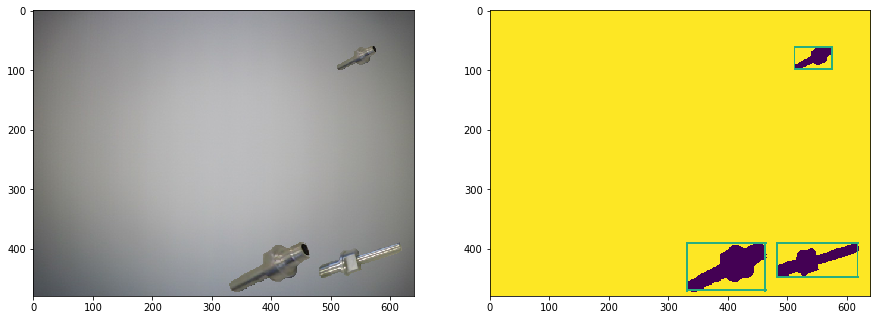

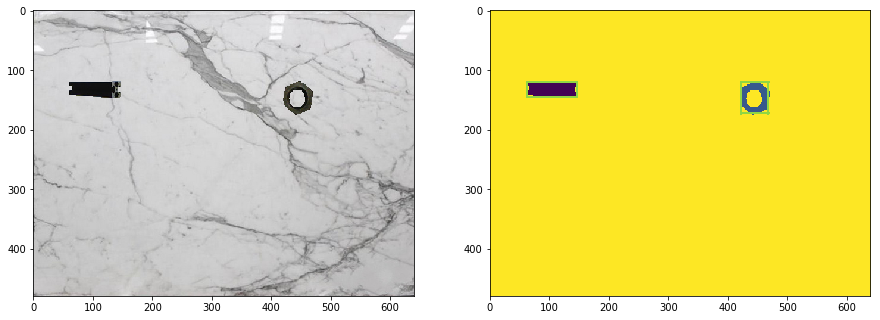

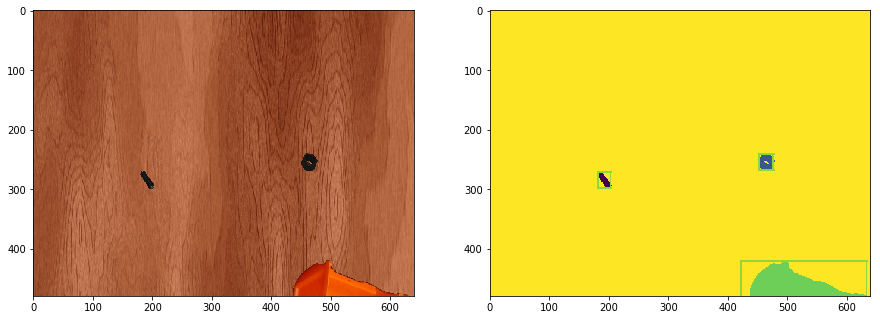

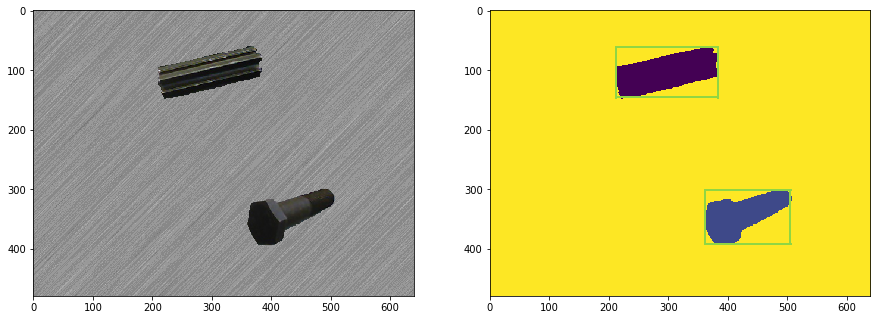

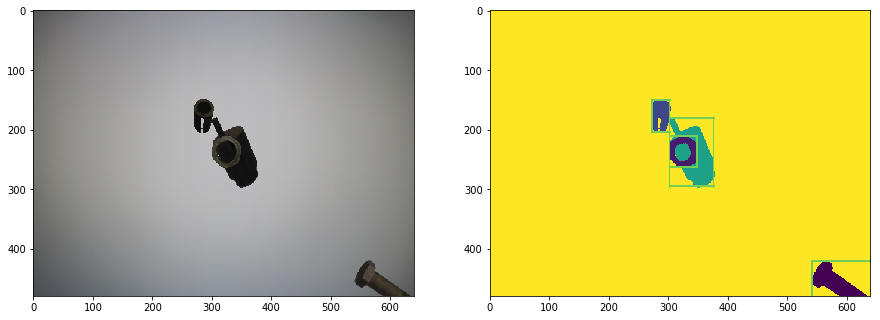

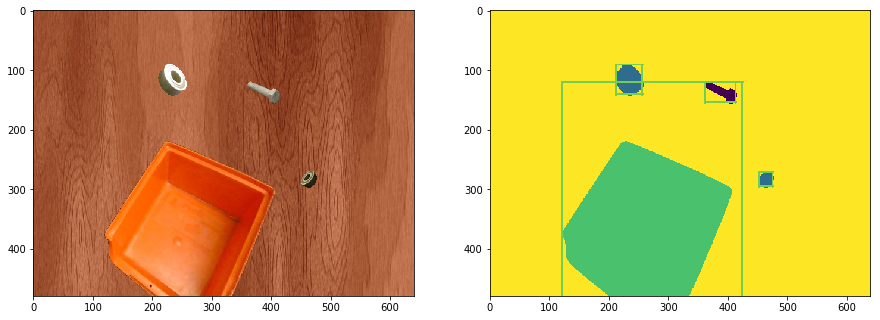

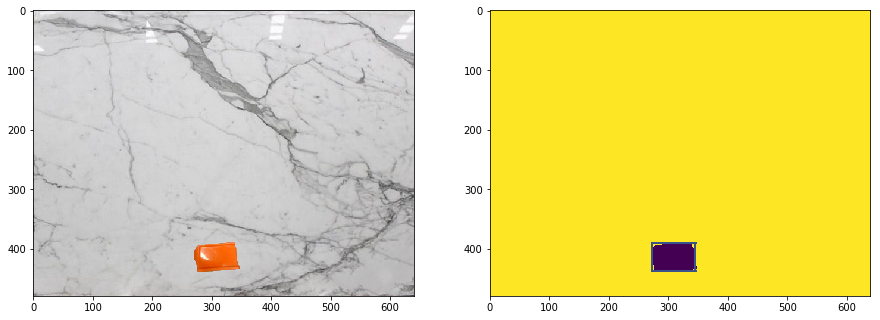

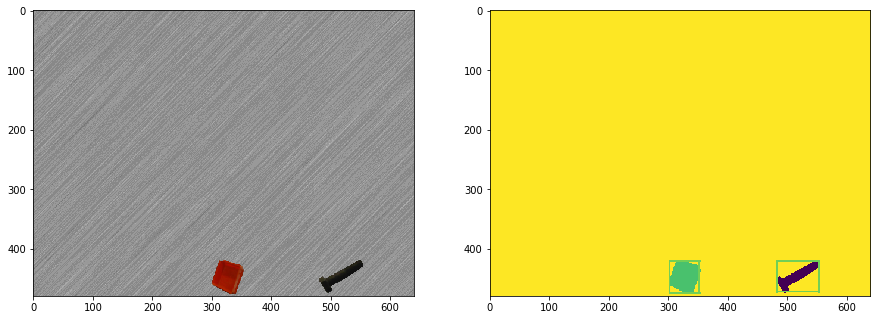

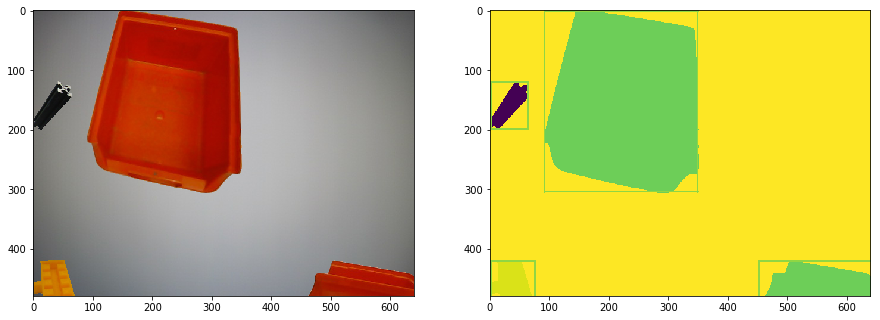

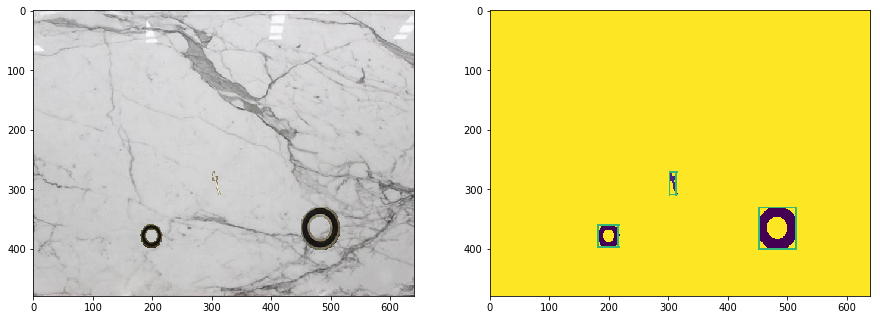

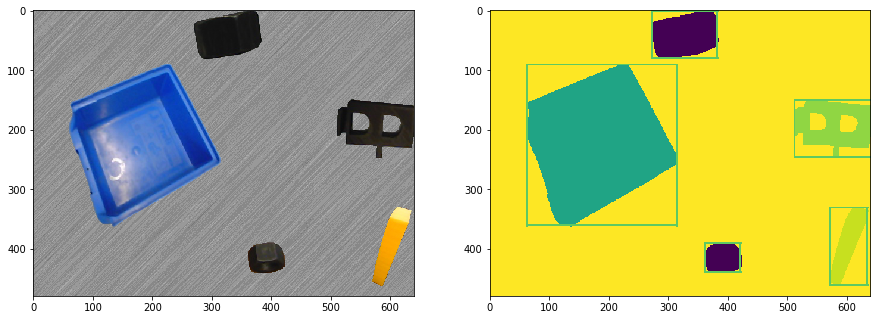

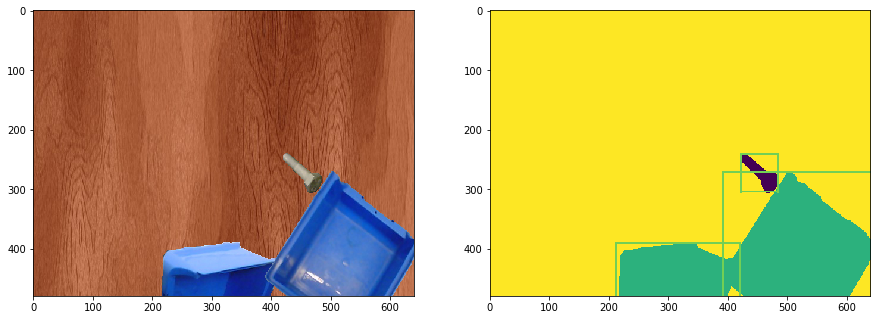

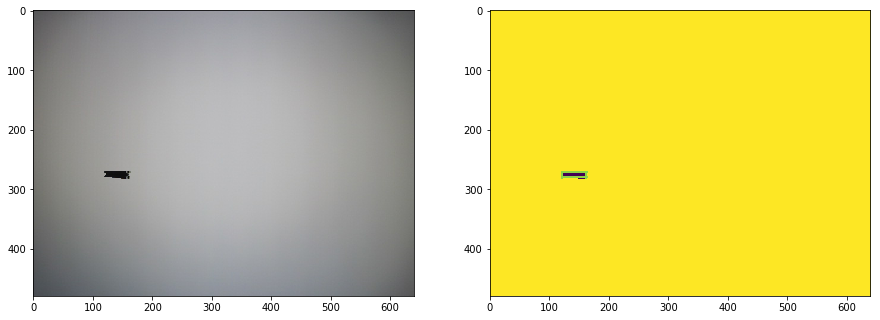

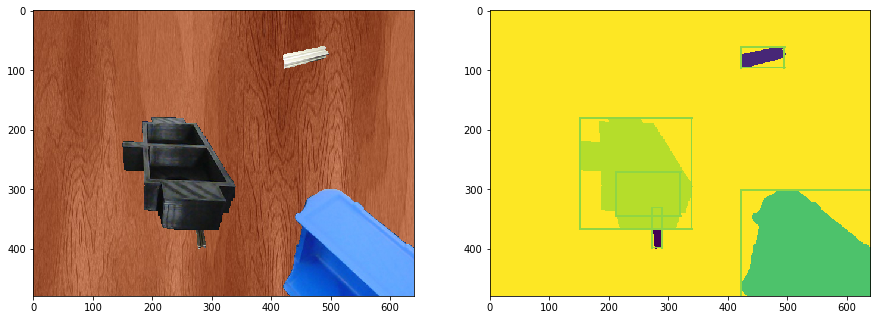

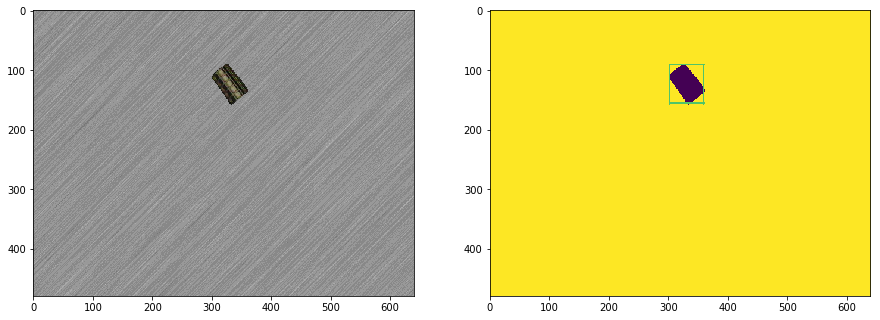

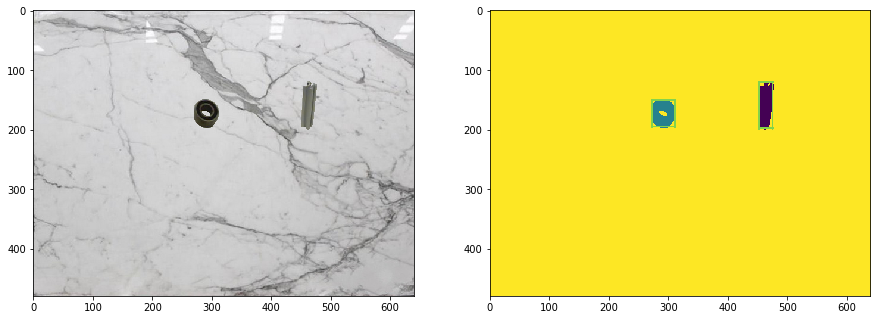

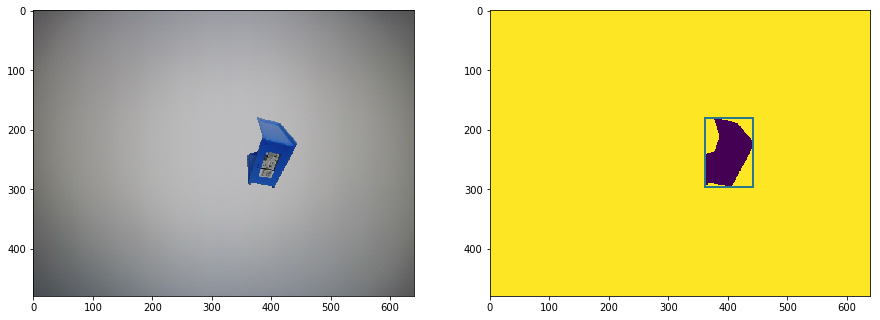

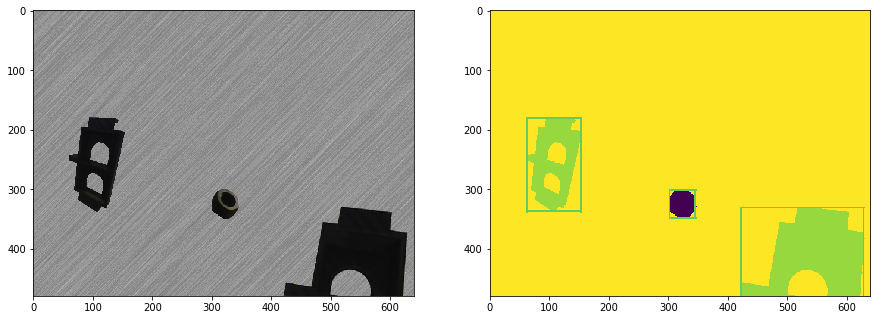

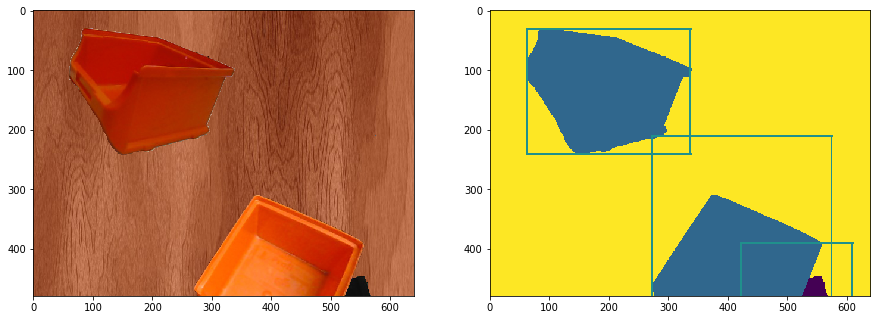

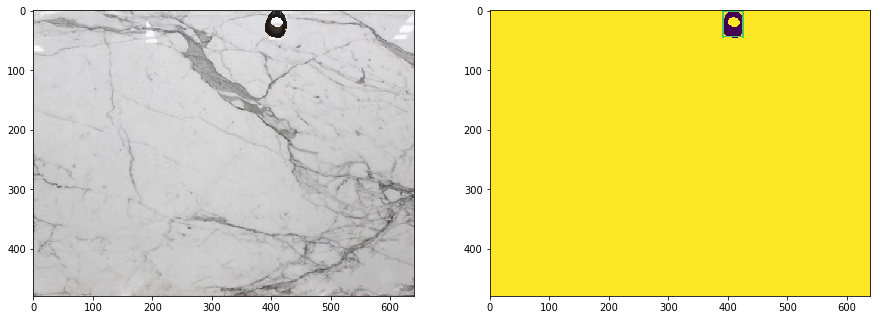

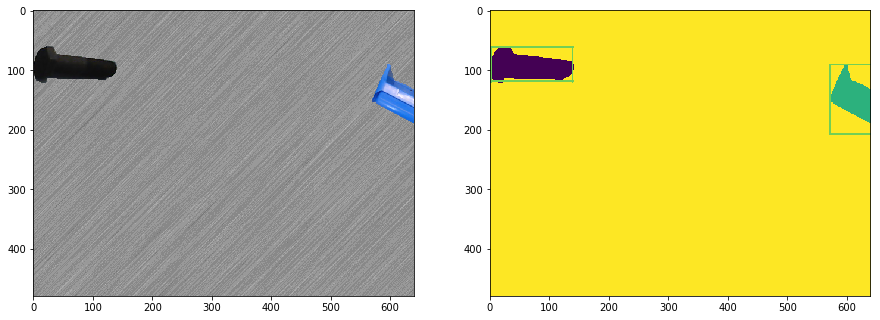

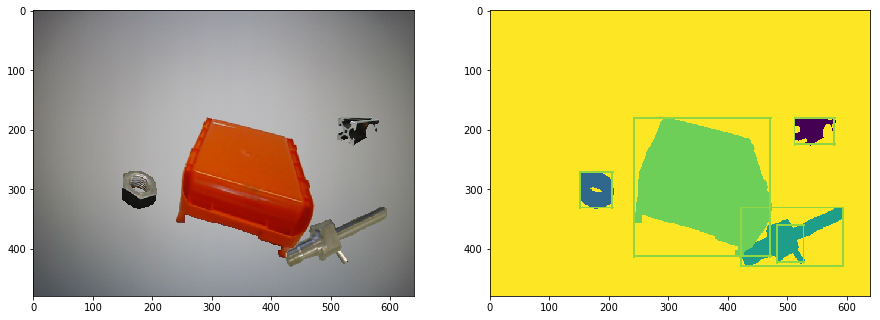

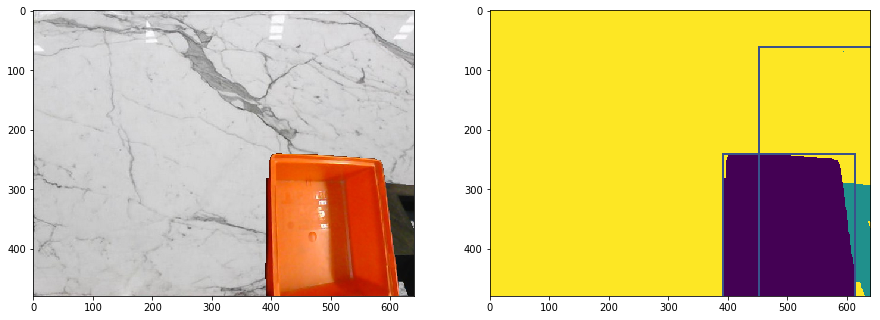

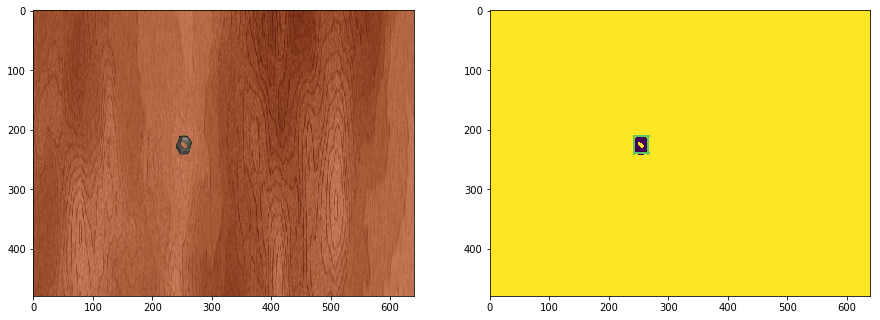

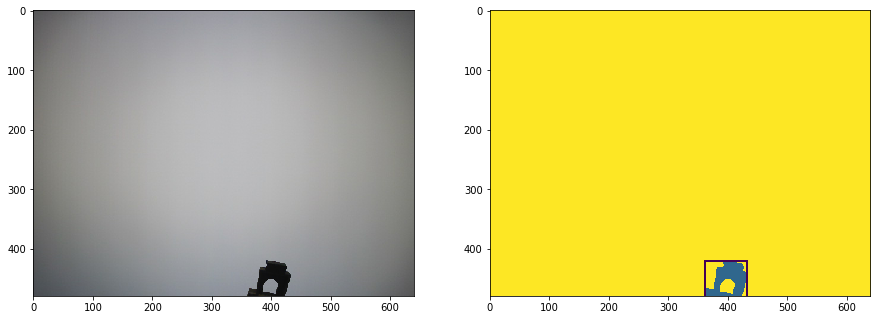

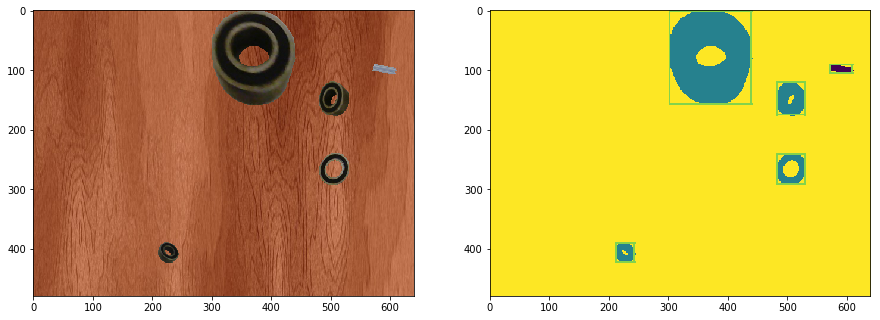

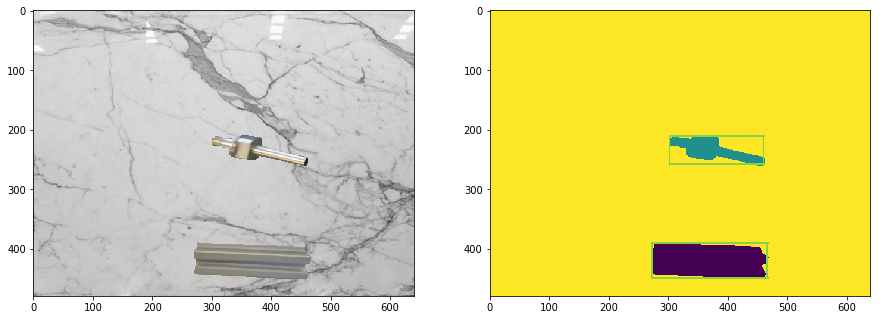

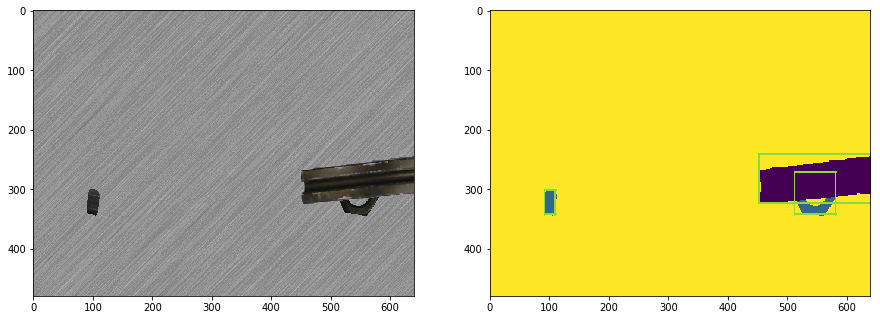

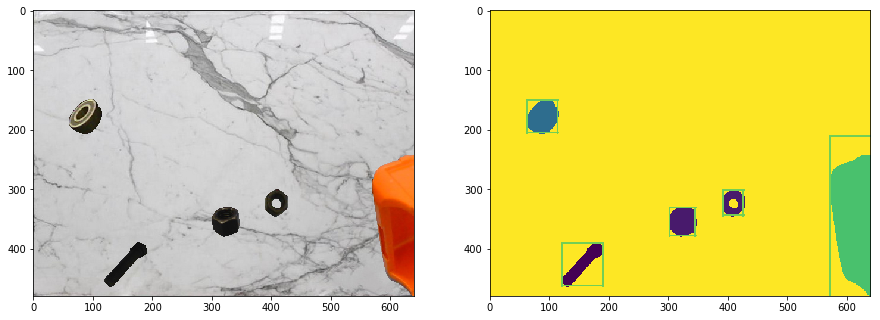

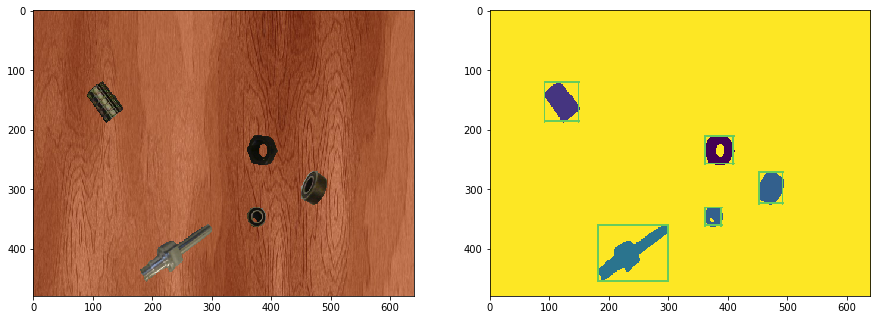

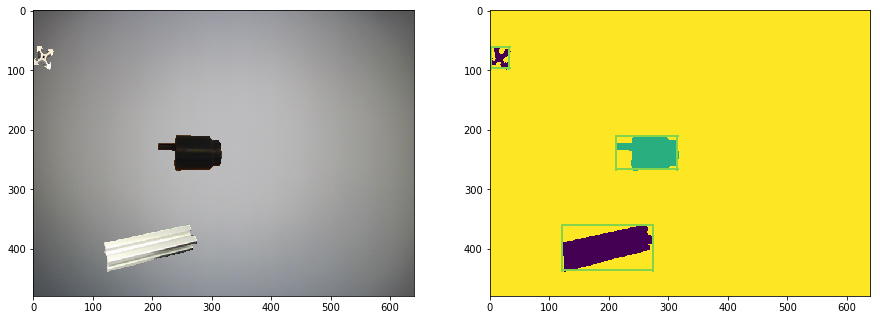

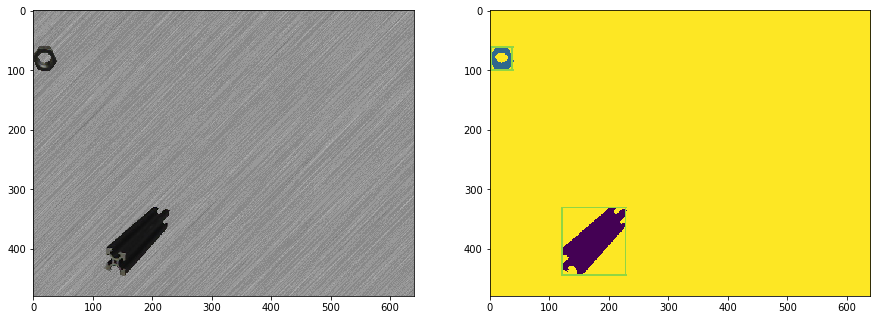

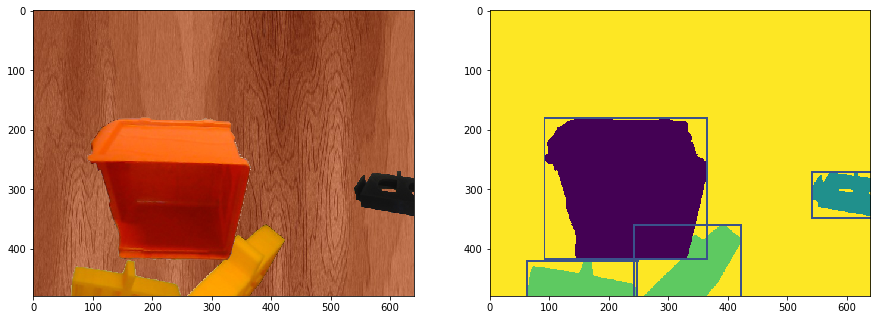

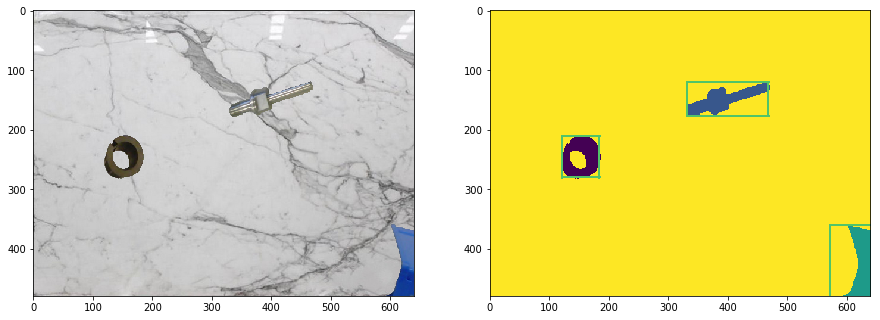

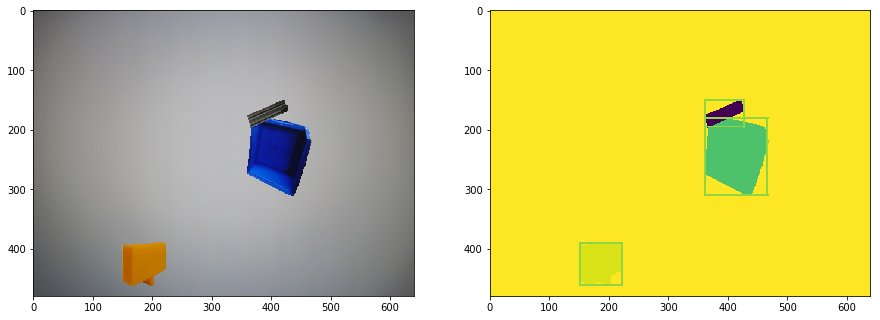

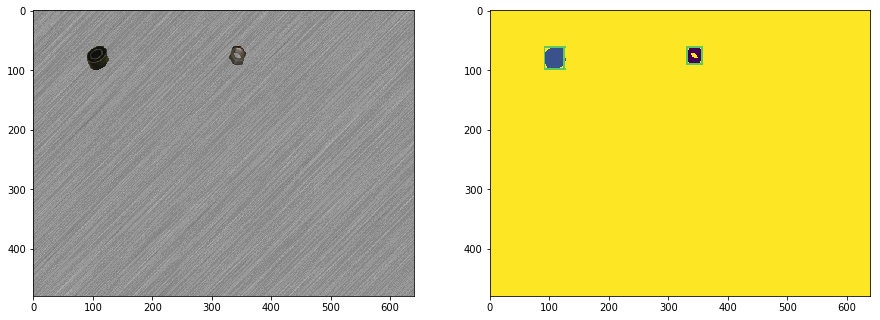

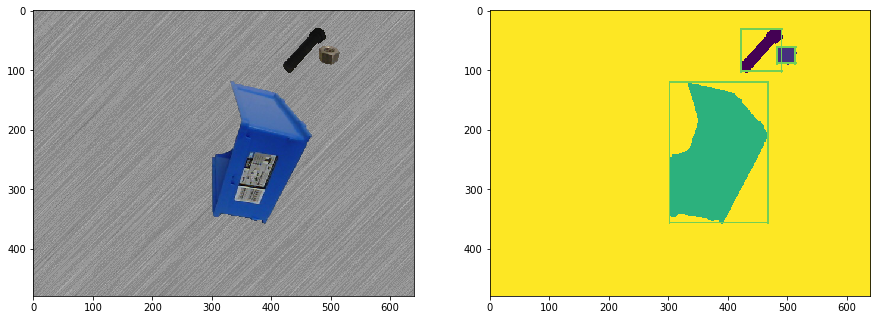

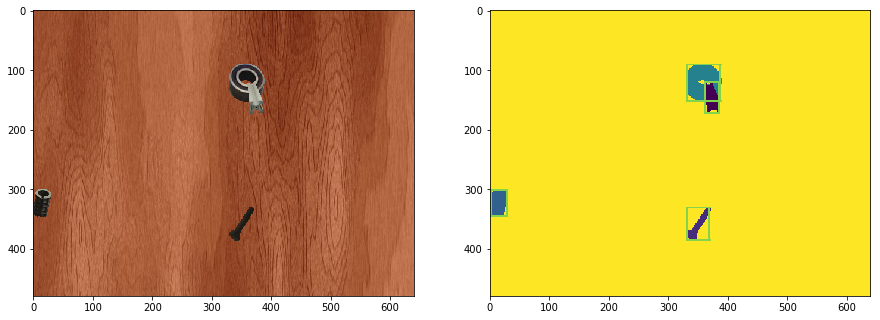

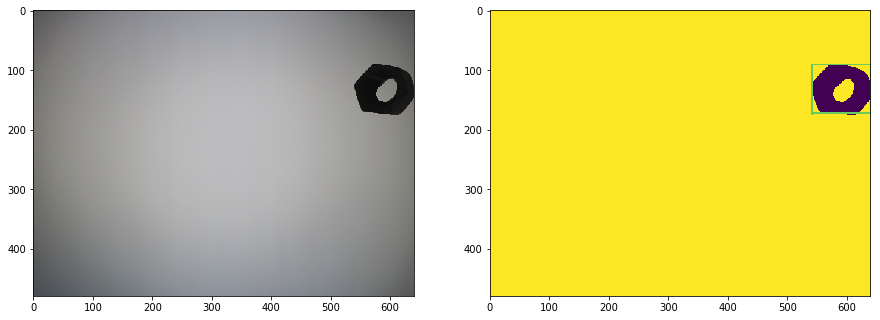

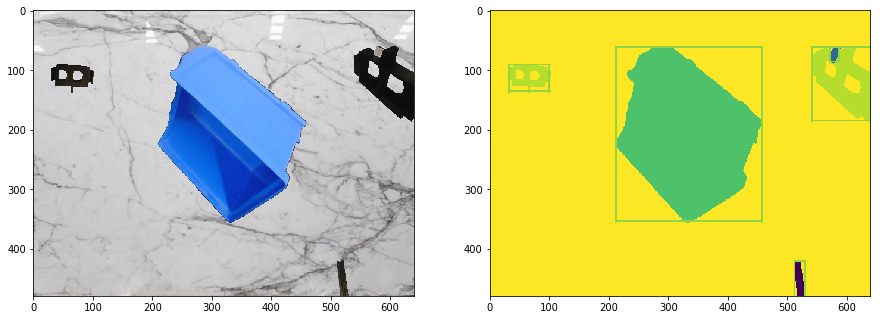

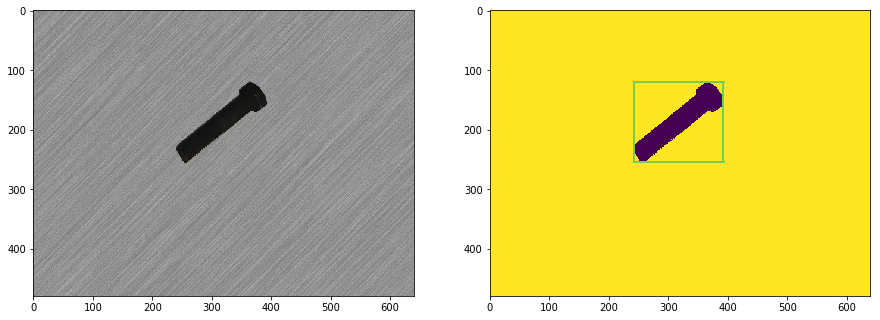

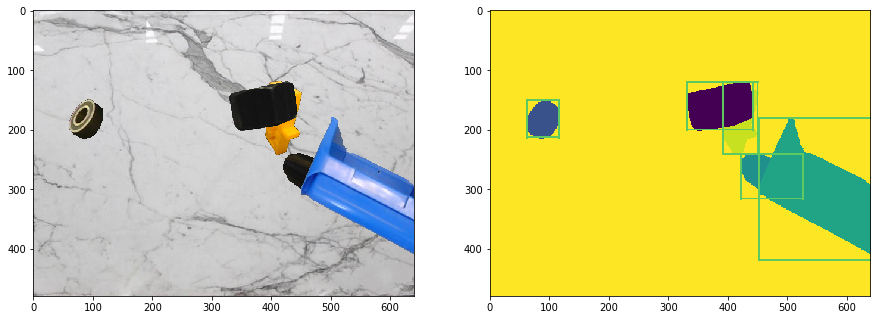

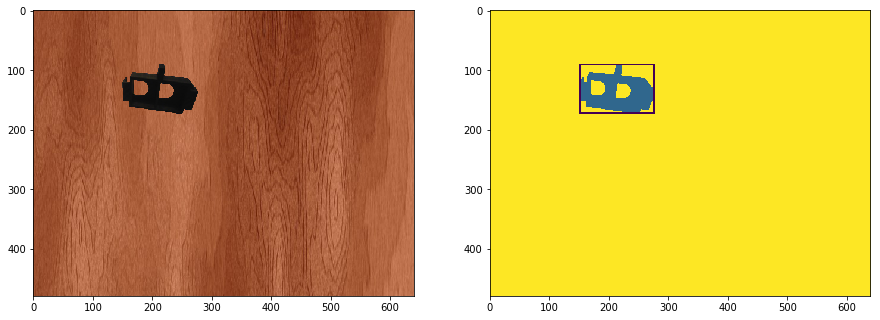

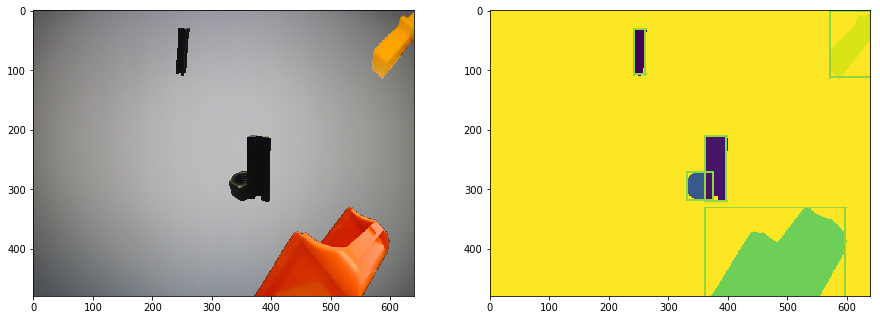

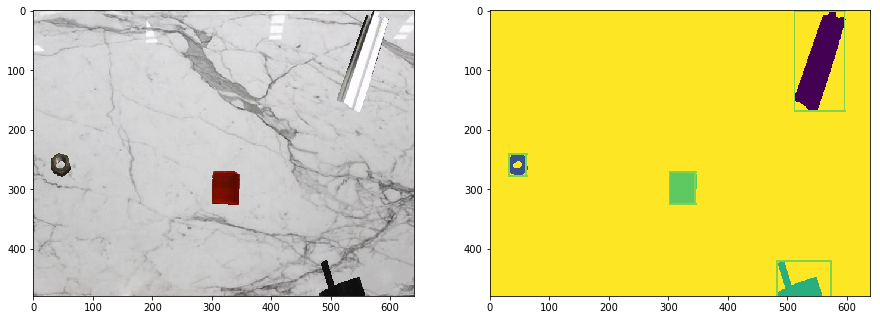

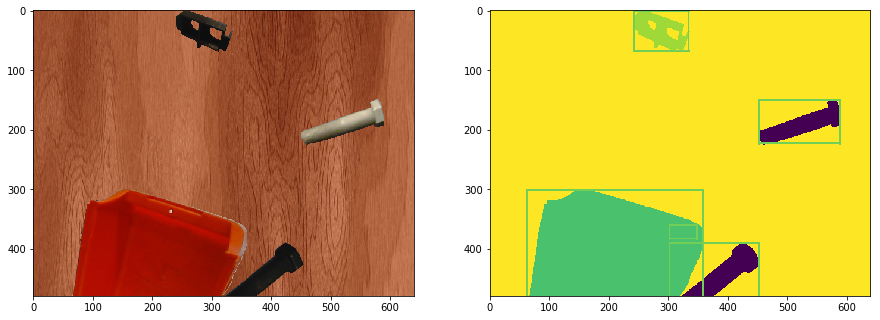

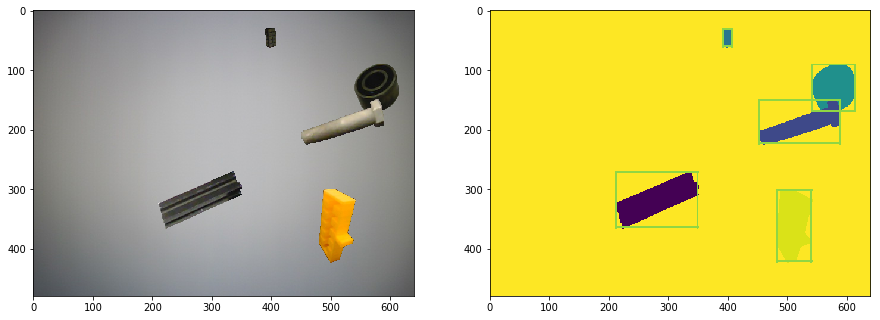

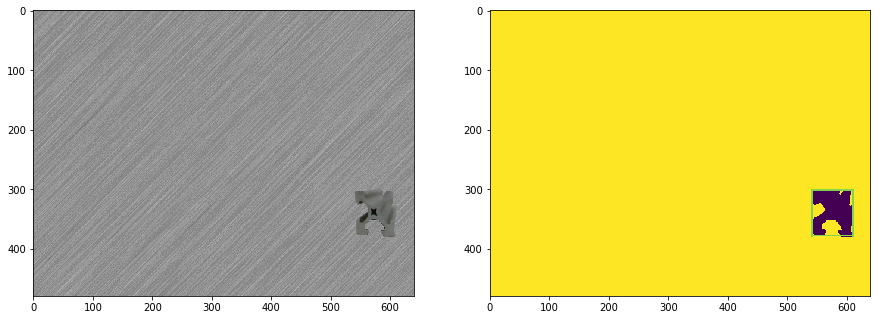

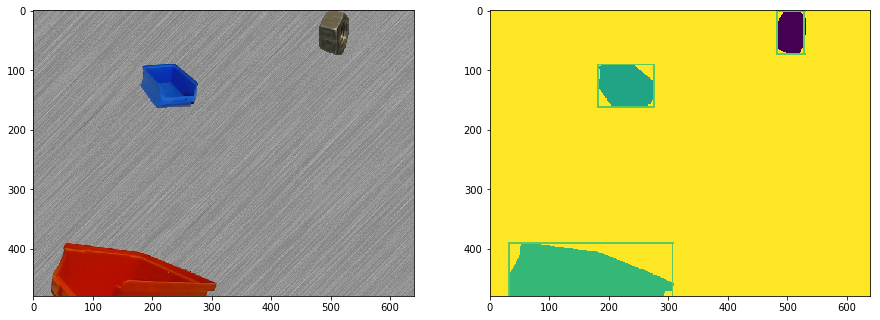

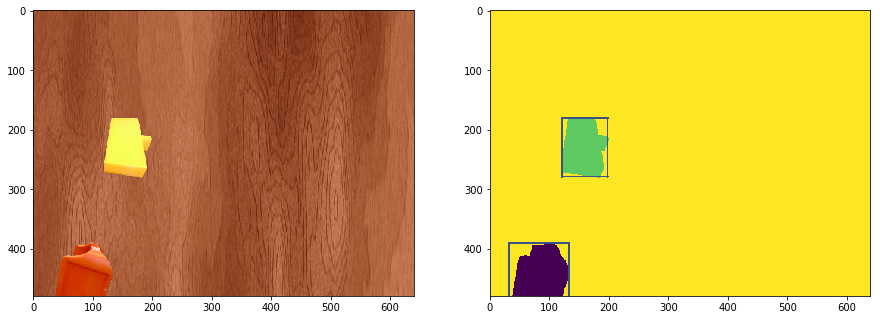

In [11]:
obj_det_label = list()
for index, vector in enumerate(augment_vector):
    augmented_image, augmented_label = vector['background_image'], background_label.copy()
    obj_det_label.clear()
    for i in range(vector['num_objects_to_place']):
        
        if GET_OBJ_DET_LABEL:
            augmented_image, augmented_label, rect_label = augment_obj(augmented_image, augmented_label, 
                                                   objects[vector['what_objects'][i]], 
                                                   vector['locations'][i])
            obj_det_label.append(rect_label)
        else:
            augmented_image, augmented_label = augment_obj(augmented_image, augmented_label, 
                                                   objects[vector['what_objects'][i]], 
                                                   vector['locations'][i])
    
    if GET_OBJ_DET_LABEL:
        plot_img_and_label(augmented_image, augmented_label, index, obj_det_label)
        cv2.imwrite('./data_augmentation_results/image/'+str(index)+'.png', augmented_image)
        cv2.imwrite('./data_augmentation_results/ground_truth/'+str(index)+'.png', augmented_label)
        with open('./data_augmentation_results/obj_det/'+str(index)+'.csv','w') as f:
            wr = csv.writer(f,delimiter=',')
            [wr.writerow(l) for l in obj_det_label]
            
    else:
        plot_img_and_label(augmented_image, augmented_label, index)
        cv2.imwrite('./data_augmentation_results/image/'+str(index)+'.png', augmented_image)
        cv2.imwrite('./data_augmentation_results/ground_truth/'+str(index)+'.png', augmented_label)

In [12]:
import cv2
import matplotlib.pyplot as plt

In [13]:
img = cv2.imread('./data_augmentation_results/ground_truth/0.png',0)

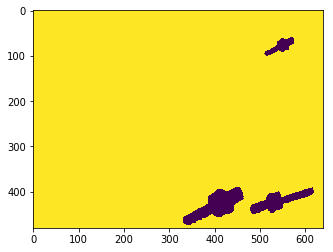

In [14]:
plt.imshow(img)
plt.show()